# Volume 3: Kalman Filter
    Samuel Goldrup
    Math 405
    7 March 2023

In [1]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

In [2]:
import numpy as np
import matplotlib
matplotlib.use('nbAgg')
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
from scipy.linalg import inv, norm

## Problem 1

Begin implementing a KalmanFilter class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

## Problem 3

Add a method evolve() to your KalmanFilter class to generate a state and observation sequence by evolving the system from a given initial state.


## Problem 4
Add code to your KalmanFilter class to estimate a state sequence corresponding to a given observation sequence and initial state estimate by implementing the estimate() method.

## Problem 6

Add a function predict() to your class that predicts the next $k$ states given a current state estimate but in the absence of observations.

## Problem 8
Add a function rewind() to your class that rewinds the system from a given state estimate, returning predictions for the previous states. 

In [3]:

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        n = x0.shape[0] 
        m = (self.H @ x0).shape[0]
        states = np.empty((n,N))
        obs = np.empty((m,N))
        
        states[:,0] = x0
        obs[:,0] = x0[:2]
        for i in range(1,N):
            x1 = self.F @ x0 + self.u + np.random.multivariate_normal(np.zeros(n),self.Q)
            z1 = self.H @ x1 + np.random.multivariate_normal(np.zeros(m),self.R)
            x0 = x1
            states[:,i] = x1
            obs[:,i] = z1
            
        return states, obs                      
          

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        n,N = x0.shape[0], z.shape[1]
 
        out = np.empty((n,N))
        out[:,0] = x0
        
        xk1_k1 = x0
        Pk1_k1 = P0
        
        for k in range(1,N):
            xk_k1 = self.F @ xk1_k1 + self.u #predictions
            Pk_k1 = self.F @ Pk1_k1 @ self.F.T + self.Q
            
            y_hat_k = z[:,k] - self.H @ xk_k1 #updates
            S_k = self.H @ Pk_k1 @ self.H.T + self.R
            K_k = Pk_k1 @ self.H.T @ np.linalg.inv(S_k)
            xk_k = xk_k1 + K_k @ y_hat_k
            Pk_k = (np.eye(n) - K_k@self.H) @ Pk_k1
            
            out[:,k] = xk_k
            
            xk1_k1 = xk_k
            Pk1_k1 = Pk_k
            
        return out  
            
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        n = x.shape[0]
        out = np.empty((n,k))
        for i in range(k):
            out_i = self.F @ x + self.u
            out[:,i] = out_i
            x = out_i
        
        return out
        
        
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        n = x.shape[0]
        out = np.empty((n,k))
        for i in list(range(k-1,-1,-1)):
            out_i = np.linalg.inv(self.F) @ (x - self.u)
            out[:,i] = out_i
            x = out_i
        
        return out

## Problem 2 

Work out the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to the projectile. 
Assume that the noise covariances are given by 

$\begin{align*}
    Q &= 0.1 \cdot I_4 \\
    R &= 5000 \cdot I_2.
\end{align*}$

Instantiate a KalmanFilter object with these values.

In [4]:
Q = 0.1*np.eye(4)
R = 5000*np.eye(2)
F = np.array([[1,0,.1,0],[0,1,0,.1],[0,0,1,0],[0,0,0,1]])
u = np.array([0,0,0,-0.98])
H = np.array([[1,0,0,0],[0,1,0,0]])

KF = KalmanFilter(F,Q,H,R,u)

## Problem 3

Simulate the true and observed trajectory of a projectile with initial state

$\begin{equation*}
    x_0 = \left( \begin{array}{c} 0 \\ 0 \\ 300 \\ 600 \end{array} \right).
\end{equation*}$

In [5]:
x0 = np.array([0,0,300,600])
N = 1250

states, obs = KF.evolve(x0,N)

<IPython.core.display.Javascript object>


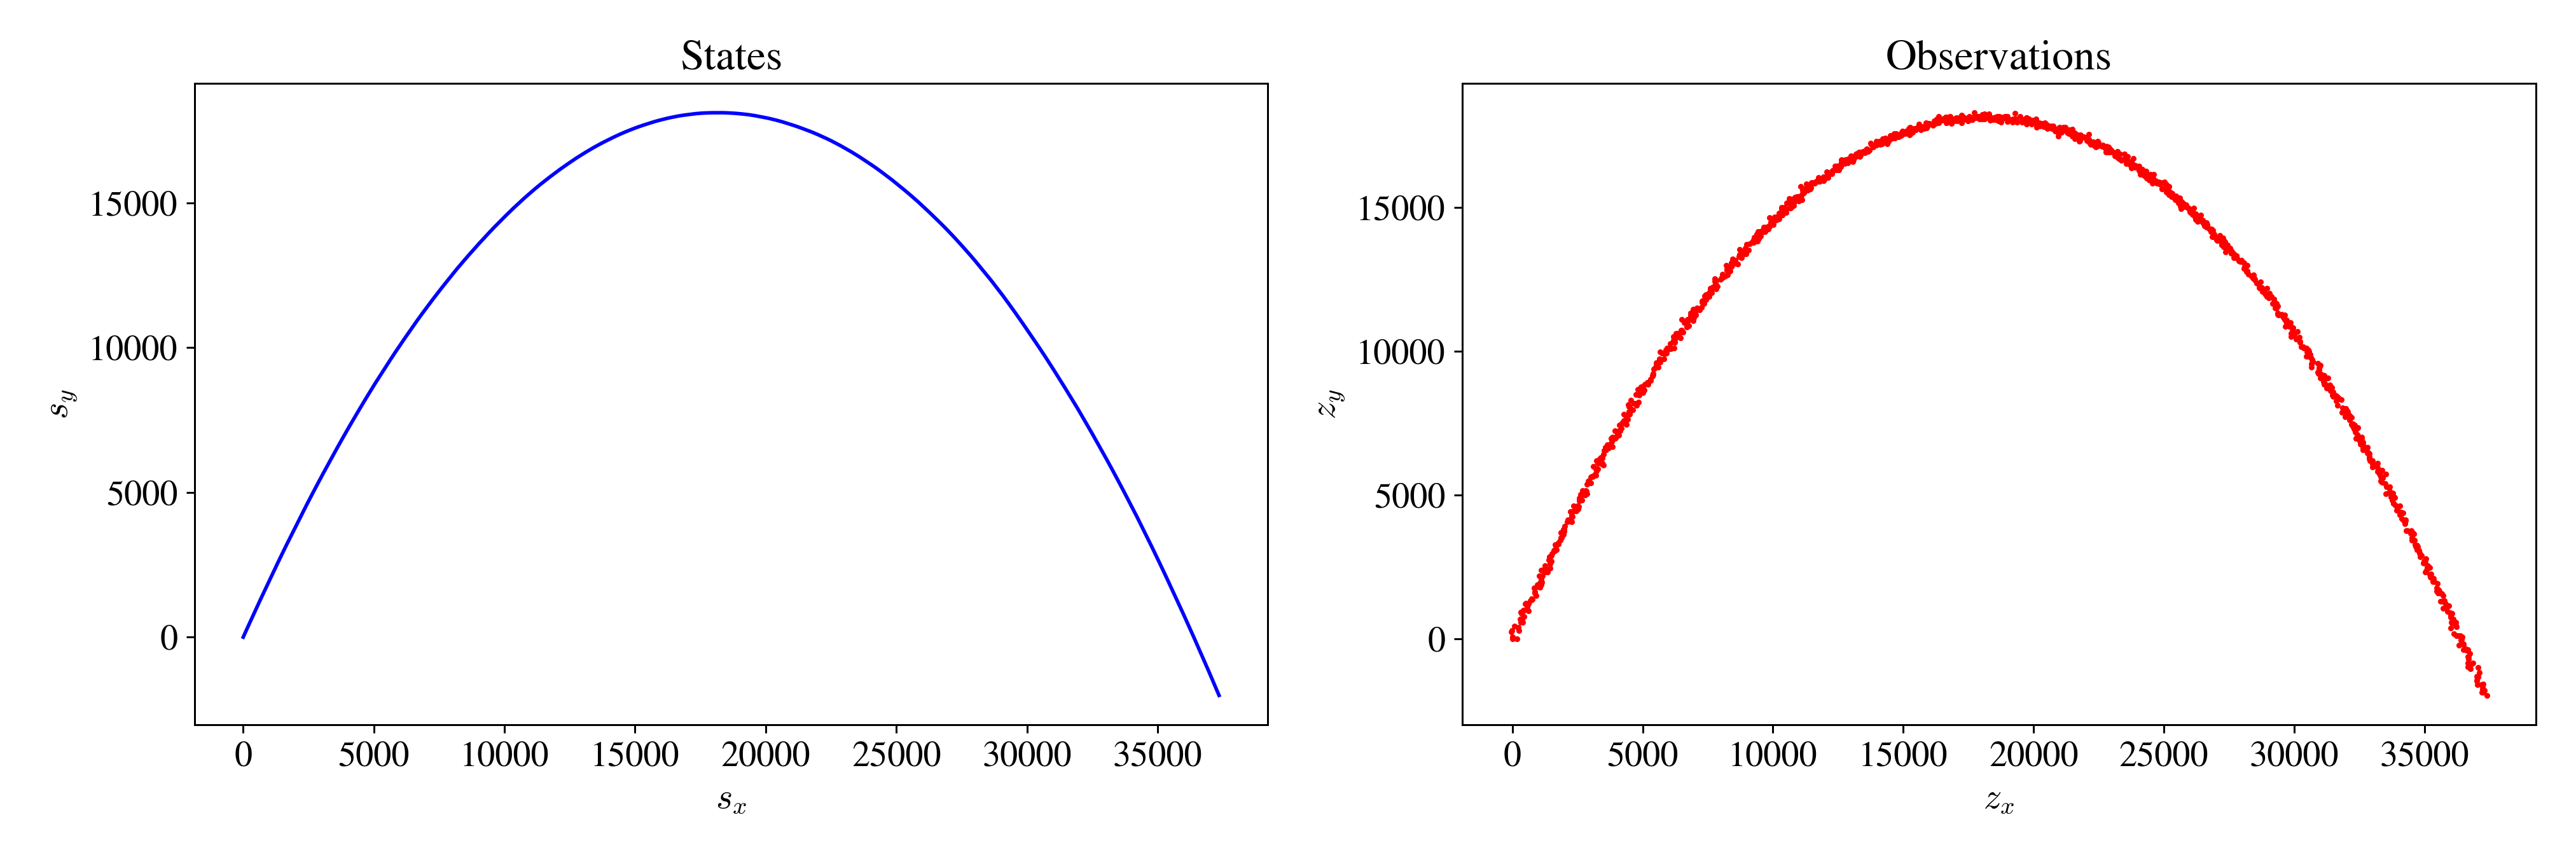

In [6]:
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1).plot(states[0],states[1],color="blue")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.title("States")

plt.subplot(1,2,2).scatter(obs[0],obs[1],color="red",s=2)
plt.xlabel("$z_{x}$")
plt.ylabel("$z_{y}$")
plt.title("Observations")

plt.tight_layout()
plt.show()

## Problem 5

Calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.
Using the initial state estimate, $P_{200} = 10^6\cdot Q$, and your Kalman Filter, compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
Zoom in to see how well it follows the true path. 

In [7]:
s_x,s_y = obs[:,200] #observed position at time 200
speeds = np.diff(obs[:,200:210],n=1,axis=1) / 0.1 #divide by step size 0.1
v_x,v_y = np.mean(speeds,axis=1)

x0 = np.array([s_x,s_y,v_x,v_y])
P0 = 1e6 * Q #P_200

z = obs[:,201:801]

estimates = KF.estimate(x0,P0,z)

<IPython.core.display.Javascript object>


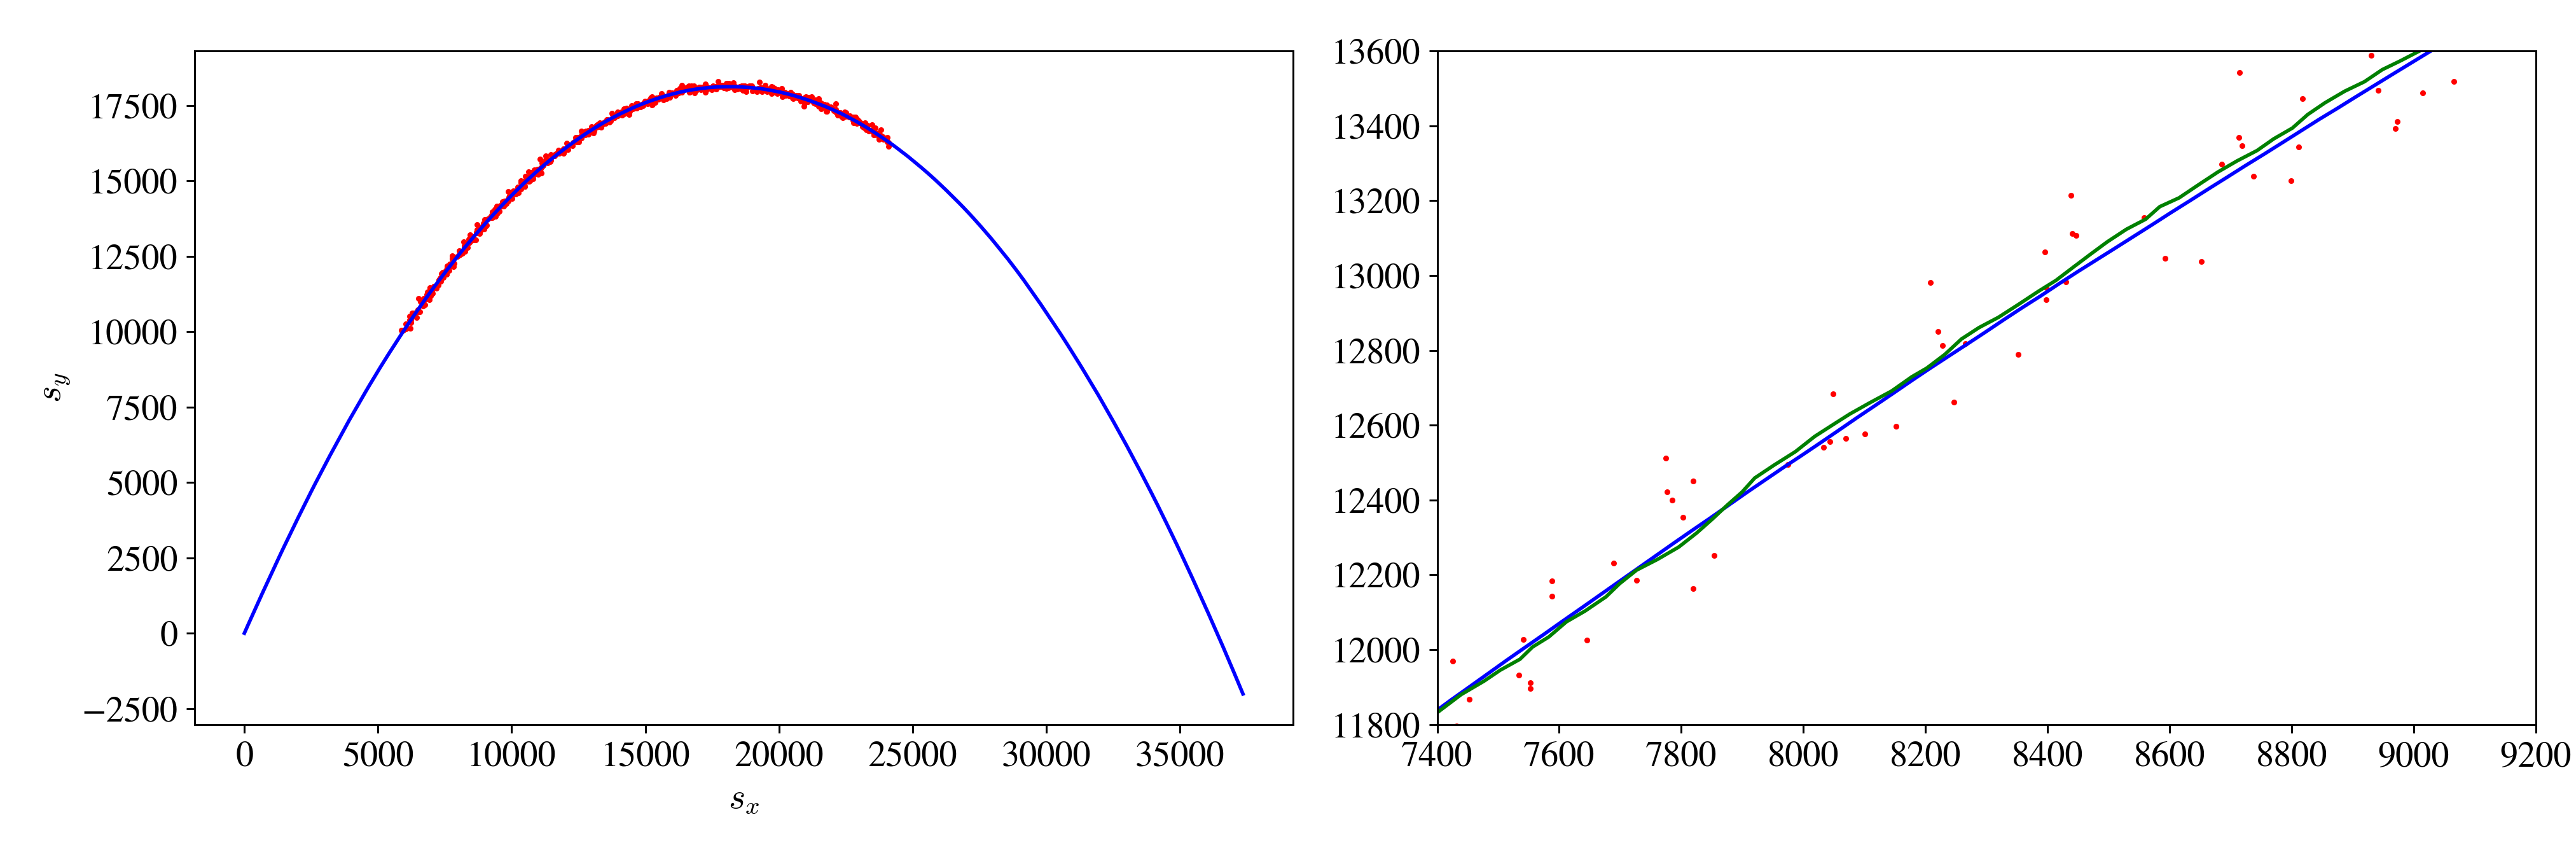

In [8]:
trunc_states = states[:,201:801]

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1).scatter(z[0],z[1],color="red",s=2)
plt.subplot(1,2,1).plot(states[0],states[1],color="blue")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
#plt.title("States")

plt.subplot(1,2,2).plot(trunc_states[0],trunc_states[1],color="blue")
plt.subplot(1,2,2).plot(estimates[0],estimates[1],color="green")
plt.subplot(1,2,2).scatter(z[0],z[1],color="red",s=2)
plt.xlim([7400,9200])
plt.ylim([11800,13600])

plt.tight_layout()
plt.show()

## Problem 7

Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 5, predict the future states of the projectile until it hits the ground. 
Predicting approximately the next 450 states should be sufficient.
Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

In [9]:
x = estimates[:,-1]
k = 450

preds = KF.predict(x,k)

<IPython.core.display.Javascript object>


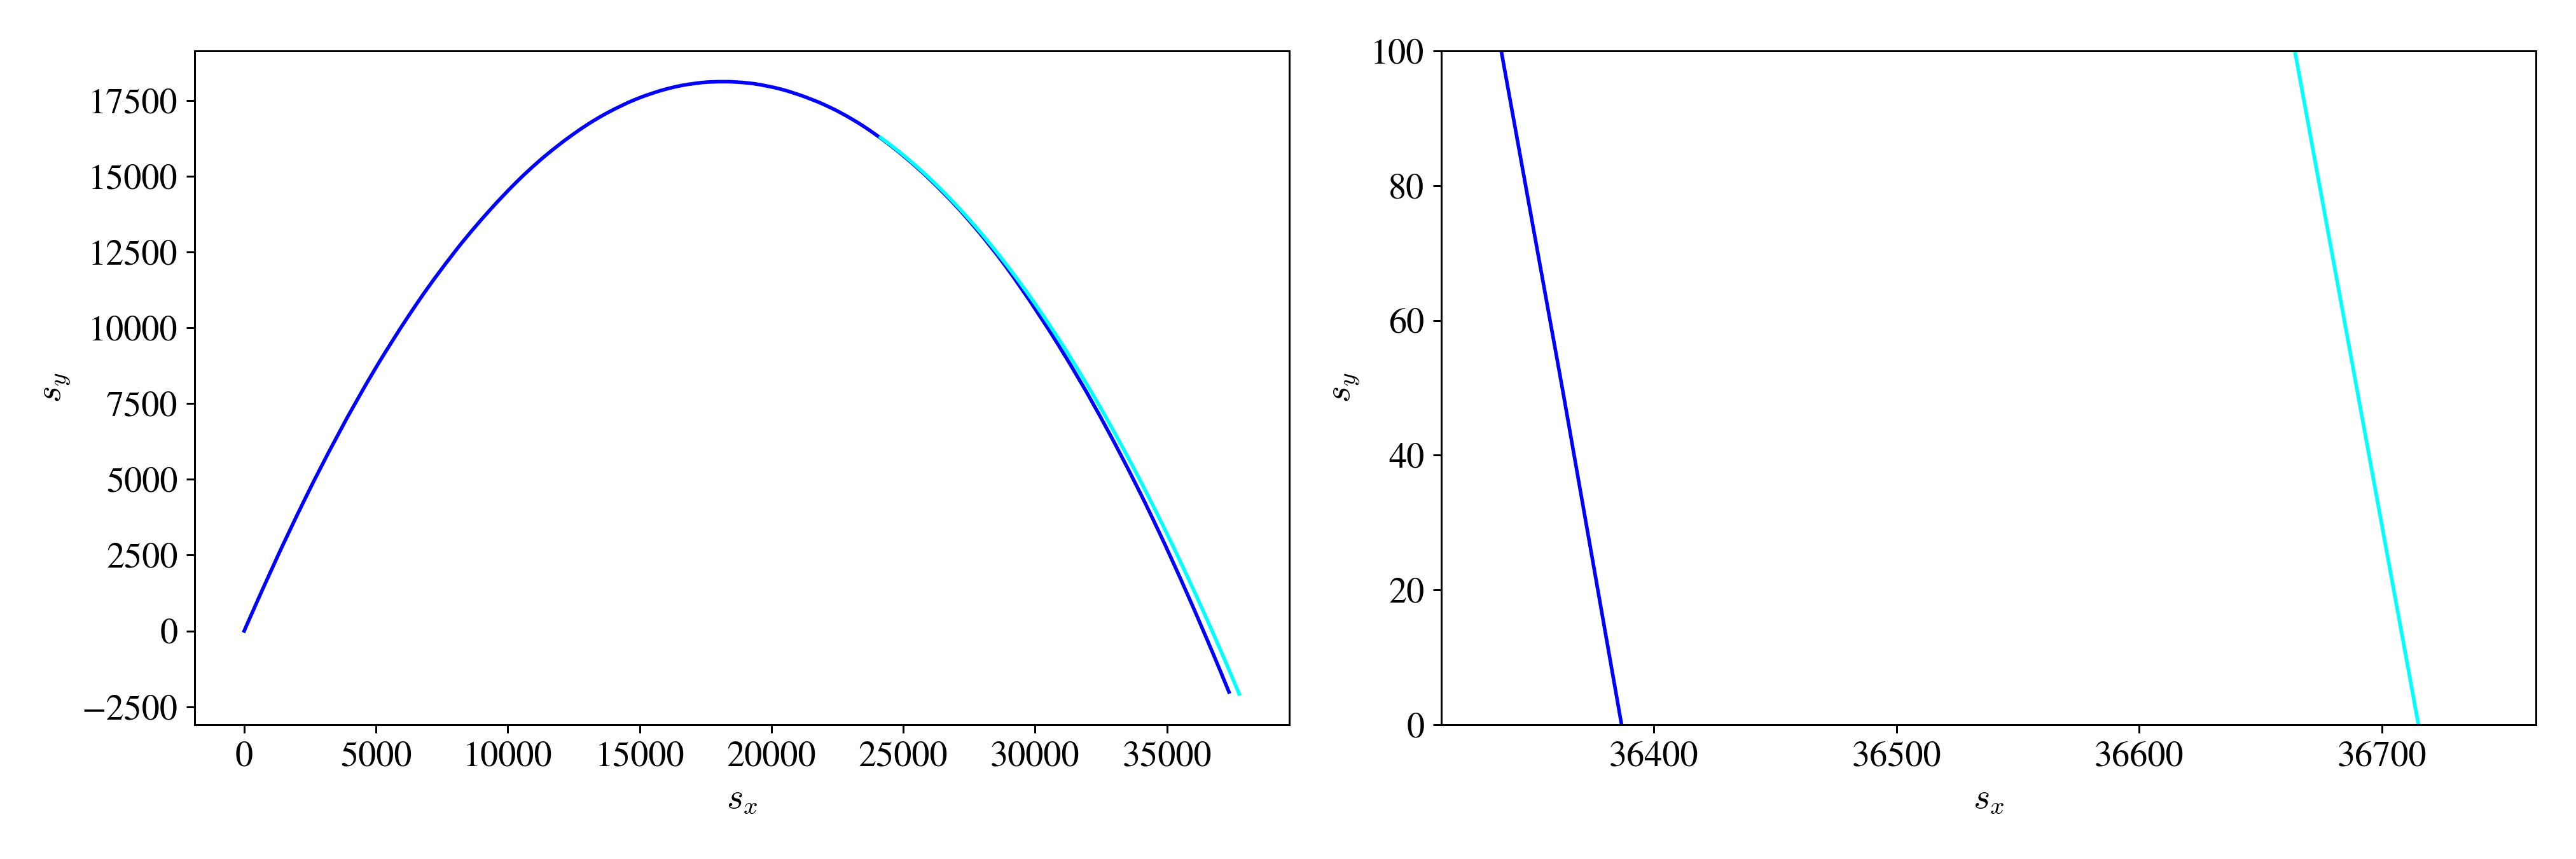

In [10]:
x1 = states[0,:][np.where(states[1,:]>=0)][-1]
x2 = preds[0,:][np.where(preds[1,:]>=0)][-1]
xlb, xub = min(x1,x2)-50, max(x1,x2)+50

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1).plot(states[0],states[1],color="blue")
plt.subplot(1,2,1).plot(preds[0],preds[1],color="cyan")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")

plt.subplot(1,2,2).plot(states[0],states[1],color="blue")
plt.subplot(1,2,2).plot(preds[0],preds[1],color="cyan")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.xlim([xlb,xub])
plt.ylim([0,100])

plt.tight_layout()
plt.show()

## Problem 9

Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250. 
Note that you may have to take a few extra time steps to predict the point of origin. 
Plot these predicted states (in green) together with the original state sequence. 
Zoom in to see how accurate your prediction is. 
Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$. 
Compare to the previous results. 
Which is better? 
Why?

In [11]:
x = estimates[:,49]
k = 260

preds = KF.rewind(x,k)

<IPython.core.display.Javascript object>


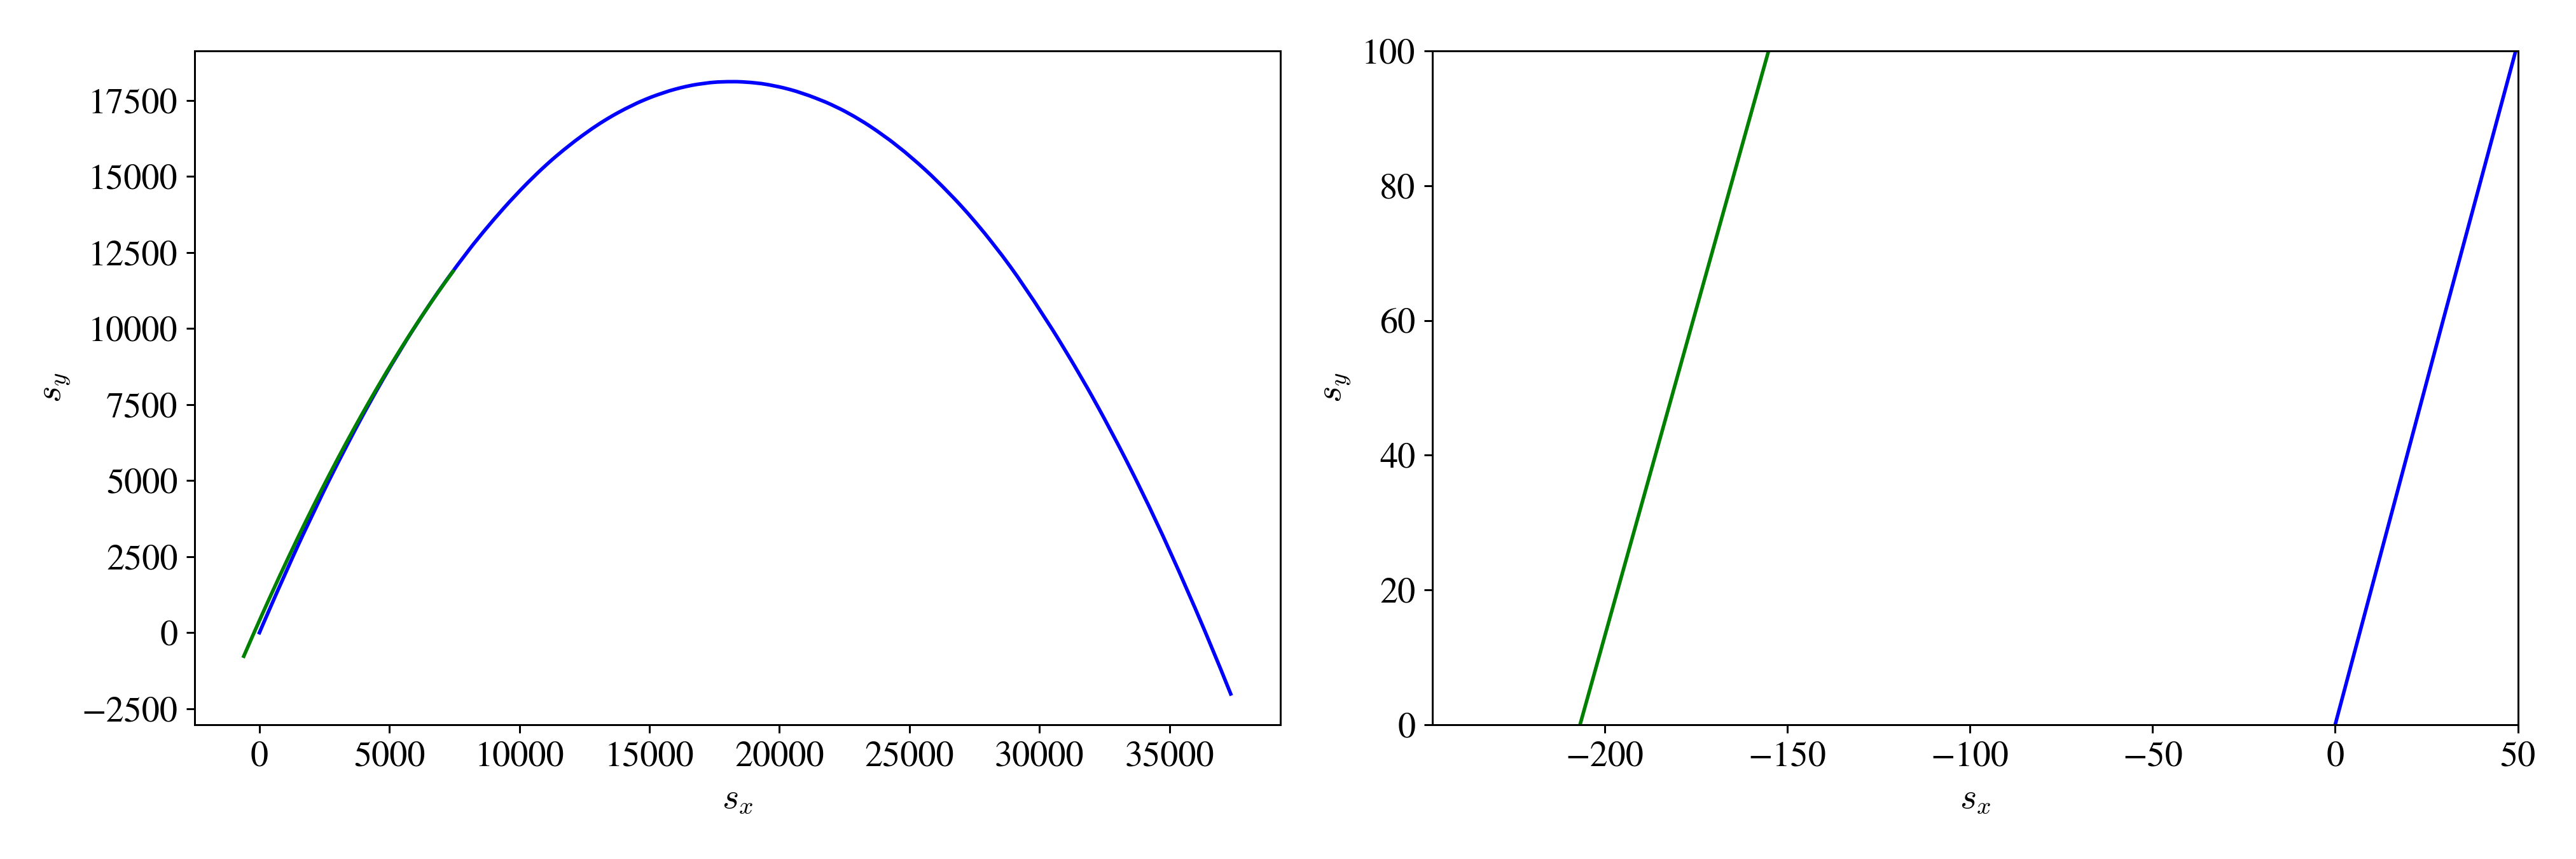

In [12]:
x1 = states[0,:][np.where(states[1,:]>=0)][0]
x2 = preds[0,:][np.where(preds[1,:]>=0)][0]
xlb, xub = min(x1,x2)-50, max(x1,x2)+50

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1).plot(states[0],states[1],color="blue")
plt.subplot(1,2,1).plot(preds[0],preds[1],color="green")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")

plt.subplot(1,2,2).plot(states[0],states[1],color="blue")
plt.subplot(1,2,2).plot(preds[0],preds[1],color="green")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.xlim([xlb,xub])
plt.ylim([0,100])

plt.tight_layout()
plt.show()

In [13]:
x = estimates[:,399]
k = 610

preds = KF.rewind(x,k)

<IPython.core.display.Javascript object>


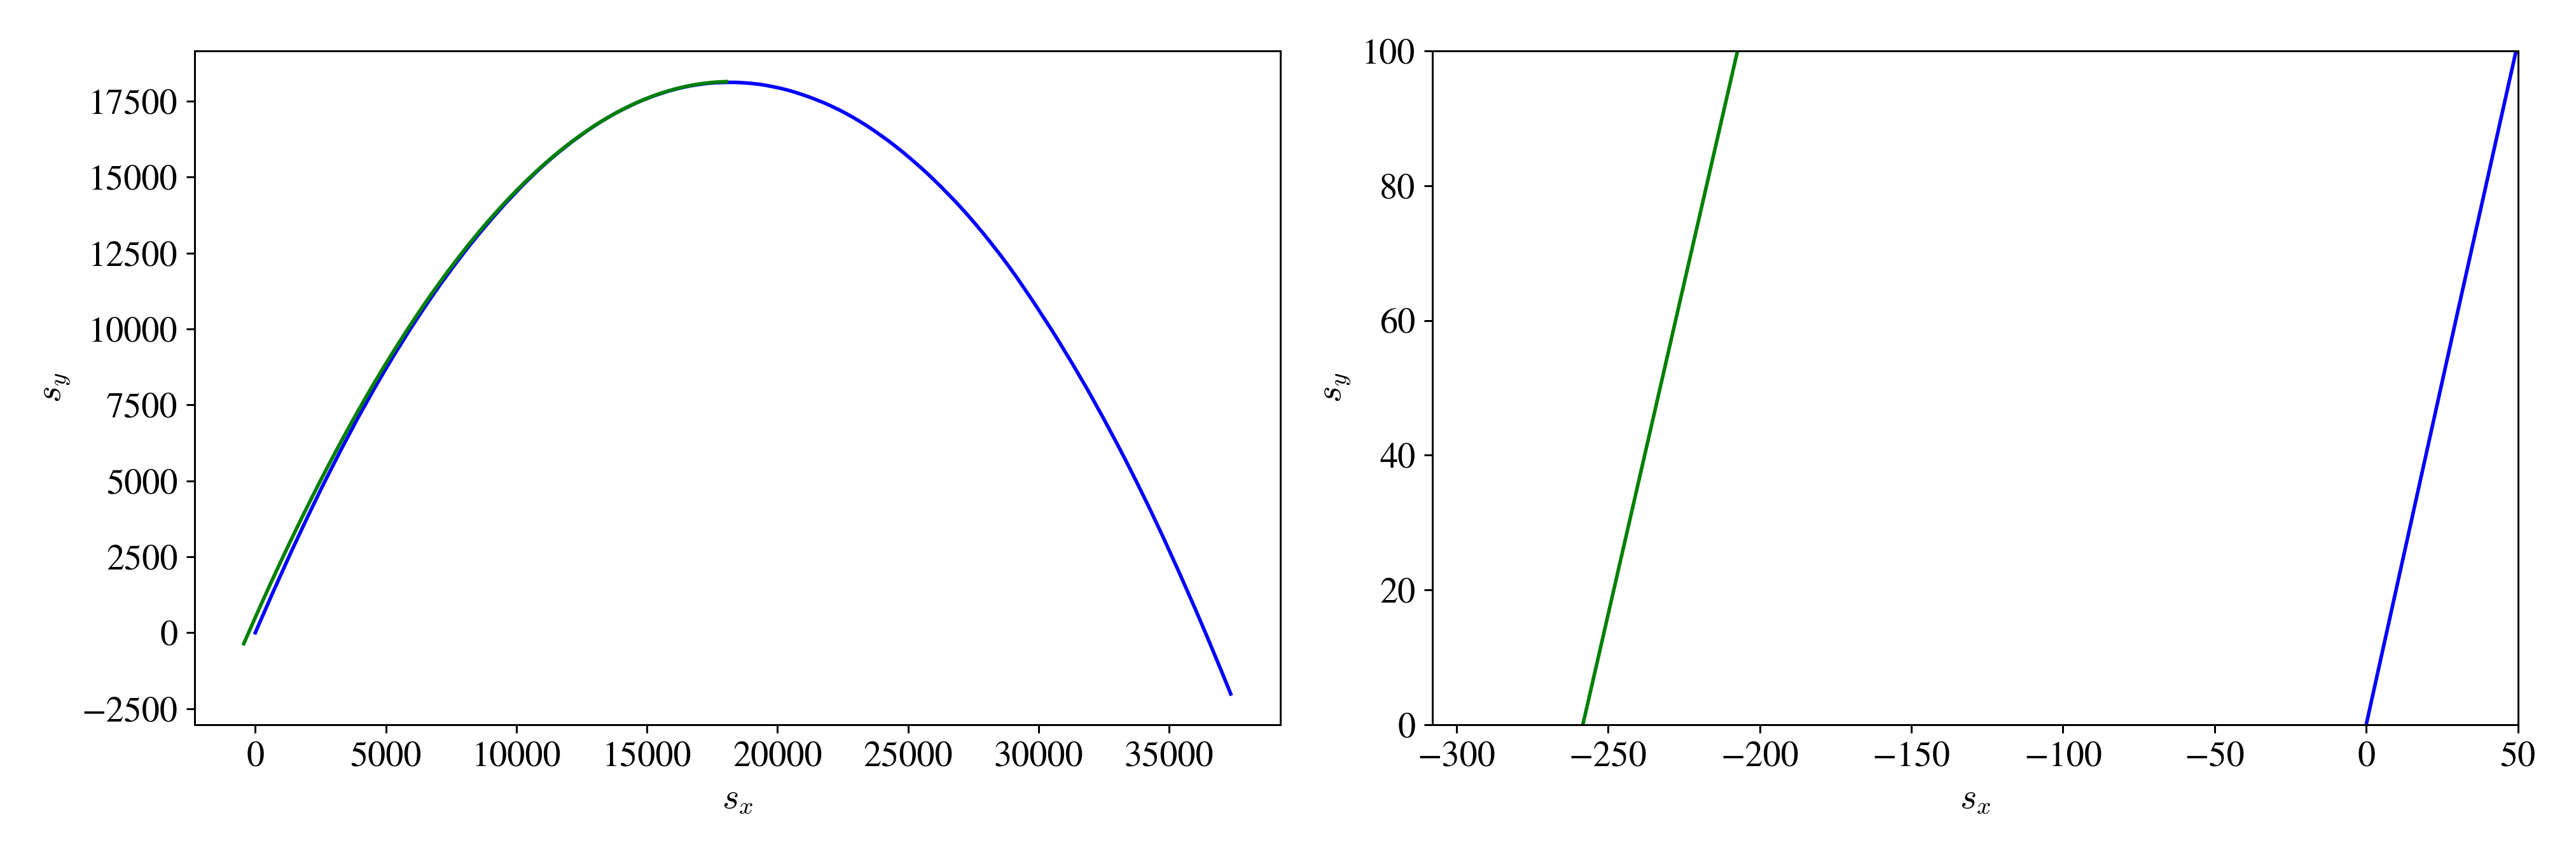

In [14]:
x1 = states[0,:][np.where(states[1,:]>=0)][0]
x2 = preds[0,:][np.where(preds[1,:]>=0)][0]
xlb, xub = min(x1,x2)-50, max(x1,x2)+50

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1).plot(states[0],states[1],color="blue")
plt.subplot(1,2,1).plot(preds[0],preds[1],color="green")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")

plt.subplot(1,2,2).plot(states[0],states[1],color="blue")
plt.subplot(1,2,2).plot(preds[0],preds[1],color="green")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.xlim([xlb,xub])
plt.ylim([0,100])

plt.tight_layout()
plt.show()

Starting at $\hat{x}_{250}$ is better than at $\hat{x}_{600}$, because it is closer (in time domain) to point of interest.